# Calibration
inspired by: http://jasss.soc.surrey.ac.uk/17/3/11.html

In [13]:
%matplotlib inline
import math
import numpy as np
import numpy.random as nrand
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import scipy.stats as stats
import powerlaw
from stockmarket import baselinemodel
import tqdm
from pandas_datareader import data
from pylab import plot, show
from math import isclose
from stockmarket.stylizedfacts import *

# Import SPY data

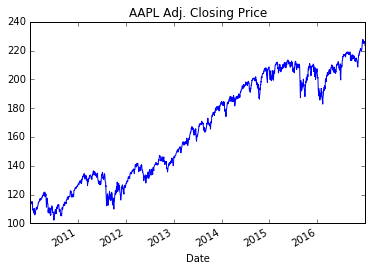

In [3]:
start_date = '2010-01-01'
end_date = '2016-12-31'

aapl = data.DataReader("SPY", 
                       start=start_date, 
                       end=end_date, 
                       data_source='google')['Close']

aapl.plot(title='AAPL Adj. Closing Price')

In [4]:
hurst(aapl, 2, 20)

0.42563522710686019

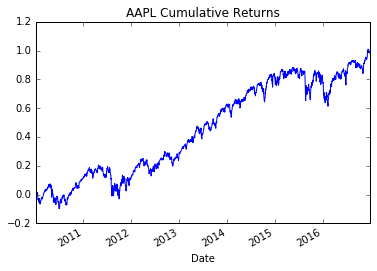

In [5]:
returns = aapl.pct_change()
((1 + returns).cumprod() - 1).plot(title='AAPL Cumulative Returns')

# Helper functions

In [6]:
# return autocorrelation close to zero after lag 1
# calculate returns 
def calculate_close(orderbook_transaction_price_history):
    closing_prices = []
    for day in orderbook_transaction_price_history:
        closing_prices.append(day[-1])
    close = pd.Series(closing_prices).pct_change()
    return close

def calculate_returns(orderbook_transaction_price_history):
    """Return the returns"""
    closing_prices = []
    for day in orderbook_transaction_price_history:
        closing_prices.append(day[-1])
    returns = pd.Series(closing_prices).pct_change()
    return returns[1:]

# Test 1
def zero_autocorrelation(returns, lags):
    """returns wether average autocorrelation is much different from zero"""
    autocorr_returns = [returns.autocorr(lag=lag) for lag in range(lags)]
    # if mean autocorrelation are between -0.1 and 0.1
    average_autocorrelation = np.mean(autocorr_returns[1:])
    if (average_autocorrelation < 0.1) and (average_autocorrelation > -0.1):
        return True
    else:
        return False

# Test 2 
def fat_tails(returns):
    results = powerlaw.Fit(returns)
    alpha = results.power_law.alpha
    print(alpha)
    if (alpha < 5) and (alpha > 2):
        return True
    else:
        return False
    
# Test 3
def clustered_volatility(returns, lags):
    absolute_returns = returns.abs()
    autocorr_abs_returns = [absolute_returns.autocorr(lag=lag) for lag in range(lags)]
    average_autocorrelation = np.mean(autocorr_abs_returns[1:])
    print(average_autocorrelation)
    if (average_autocorrelation < 0.1) and (average_autocorrelation > -0.1):
        return False
    else:
        return True

# Test 4
def long_memory(returns, hurst_function, lag1, lag2):
    h = hurst_function(returns, lag1, lag2)
    print ('h = ',h)
    return not isclose(0.5, h, abs_tol=(10**-1/2))

In [12]:
# determine parameter space
speculators = {'exp1': 10, 'exp2': 30, 'exp3': 50, 'exp4': 80} 
# for the parameters
results = {}

for key, n_speculators in sorted(speculators.items()):
    #print (key, n_speculators)
    # simulate the model
    print ('now starting ', key)
    agents, firms, stocks, order_books = baselinemodel.stockMarketSimulation(seed=0, simulation_time=1200,
                                                                                       amount_momentum=speculators[key],
                                                                                       amount_mean_reversion=speculators[key],
                                                                                       amount_noise_traders=200-speculators[key]*2,
                                                                                       amount_firms=1,
                                                                                       initial_money=(15, 19),
                                                                                       initial_bid_ask=(1,1),
                                                                                       initial_ma_short=(20,40),
                                                                                       initial_ma_long=(120,150),
                                                                                       initial_profit=(200,200),
                                                                                       initial_book_value=(10000, 10000),
                                                                                       initial_stock_amount=4000,
                                                                                       order_expiration_time=150,
                                                                                       init_propensity_to_switch=1.1,
                                                                                       init_price_to_earnings_window=((4, 7), (10, 14)),
                                                                                       firm_profit_mu=0.058,
                                                                                       firm_profit_delta=0.00396825396,
                                                                                       firm_profit_sigma=0.125,
                                                                                       profit_announcement_working_days=20,
                                                                                       agents_hold_thresholds=(0.9995, 1.0005),
                                                                                       init_backward_simulated_time=200,
                                                                                       trader_volume_risk_aversion=0.1,
                                                                                       order_variability=1.5,
                                                                                       printProgress=False
                                                                                       )
    # Apply the tests 
    # apply all tests to the model 
    # test 1
    first_test = zero_autocorrelation(calculate_returns(order_books[0].transaction_prices_history), 25)
    # test 2
    second_test = fat_tails(calculate_returns(order_books[0].transaction_prices_history))
    # test 3
    third_test = clustered_volatility(calculate_returns(order_books[0].transaction_prices_history), 25)
    # test 4
    fourth_test = long_memory(calculate_returns(order_books[0].transaction_prices_history), hurst, 2, 20)
    # save parameter space and test results
    results[key] = [first_test, second_test, third_test, fourth_test]

results

now starting  exp1
day is  600
day is 

Calculating best minimal value for power law fit
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:1138: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:1157: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))
C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:698: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


 1000
3.61016649072
0.0224431284521
h =  -0.0255297320862
now starting  exp2
day is  600
day is 

C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit

 1000
4.30906493971
0.0169788038241
h =  -0.0303327000604
now starting  exp3
day is  600
day is 


Calculating best minimal value for power law fit

 1000
4.85644574007
0.0709521445173
h =  -0.0190424372784
now starting  exp4
day is  600
day is 


Calculating best minimal value for power law fit

 1000
3.61406868557
0.040750717532
h =  -0.0318050368419


{'exp1': [True, True, False, True],
 'exp2': [True, True, False, True],
 'exp3': [True, True, False, True],
 'exp4': [True, True, False, True]}